# Jet pt and mass "inverting" regression with omnifold

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import omnifold as of
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import matplotlib as mpl
#####
#Delta R matched

2024-06-26 17:38:15.517934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [3]:
coffea.__version__

'2024.5.0'

### Check to see if a GPU is present for acceleration

### Get leading generator-level ("truth" or "gen") jet and match to the nearest reconstructed-level ("reco") jet

In [4]:
#coffea init
cofevents = NanoEventsFactory.from_root( {'QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_NANOAODSIM_7F142AC6-39F2-2F4F-9F97-C425A1C99A35.root':'Events'}, schemaclass=NanoAODSchema).events()
####

# Filter 0s 
cevents = cofevents[ak.num(cofevents.FatJet)>0]
cevents = cevents[ak.num(cevents.GenJetAK8)>0]
fj = cevents.FatJet
gj = cevents.GenJetAK8


#this should give fatjets closest to genjets, and since genjets are already stripped of zeroes, this should just line up (pfft just kidding)
nearest_fj = gj.nearest(fj)

gj0 = gj[:,0]          # Leading generator-level (gen) jet
fj0 = nearest_fj[:,0]  # Reco jet that matches leading gen jet

/usr/local/lib/python3.11/dist-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


### Compute $\Delta R$ between leading gen jet and matched reco jet. Require to be $< 0.2$

In [5]:
# Calculate delta r
gj_deltar_fj = gj0.delta_r(fj0)
# Find events where the delta r is < 0.2
pass_dr = gj_deltar_fj < 0.2
gj0 = gj0[pass_dr]
fj0 = fj0[pass_dr]
# Discard events with low pt
pass_pt = fj0.pt > 200.
gj0 = gj0[pass_pt]
fj0 = fj0[pass_pt]

### Divide into even and odd events to test and train the neural network

In [6]:
#pick lowest size
size_odd = len(gj0.pt[1::2])
size_even = len(gj0.pt[0::2])
size_all = size_even if size_odd > size_even else size_odd

In [7]:
even_gj0 = gj0[0::2][0:size_all]
odd_gj0 = gj0[1::2][0:size_all]
even_fj0 = fj0[0::2][0:size_all]
odd_fj0 = fj0[1::2][0:size_all]

### Arrange the jet pt and mass into the format omnifold expects

General plan is to add jet composition variables to this array and see if the resolution of the regression improves

In [9]:

odd_gen = np.column_stack((
    ak.to_numpy( odd_gj0.mass.compute() ),
    ak.to_numpy( odd_gj0.pt.compute() )
))

odd_reco = np.column_stack((
    ak.to_numpy( odd_fj0.mass.compute() ),
    ak.to_numpy( odd_fj0.pt.compute() )
))

even_gen = np.column_stack([
    ak.to_numpy(even_gj0.mass.compute() ),
    ak.to_numpy(even_gj0.pt.compute() )
])

even_reco = np.column_stack([
    ak.to_numpy(even_fj0.mass.compute() ) ,
    ak.to_numpy(even_fj0.pt.compute() )
])

theta0 = np.stack((odd_gen, odd_reco), axis=1)

print("CLEAR")

CLEAR


In [10]:
theta0.shape

(142194, 2, 2)

In [11]:
print(odd_gen)
print(even_gen)
print(theta0)

[[  46.5     1373.5568 ]
 [ 139.375    920.85974]
 [  96.0625  1510.5403 ]
 ...
 [ 118.3125  4407.2573 ]
 [ 148.625   2303.6921 ]
 [ 148.5     2908.3003 ]]
[[  61.21875  378.66748]
 [  61.6875   717.35364]
 [ 140.625    345.20975]
 ...
 [ 218.625   4182.6987 ]
 [  52.25     661.56055]
 [ 397.5     5961.3716 ]]
[[[  46.5     1373.5568 ]
  [  70.75    1454.     ]]

 [[ 139.375    920.85974]
  [ 132.25     885.5    ]]

 [[  96.0625  1510.5403 ]
  [  85.375   1517.     ]]

 ...

 [[ 118.3125  4407.2573 ]
  [ 124.5     2184.     ]]

 [[ 148.625   2303.6921 ]
  [ 148.625   2344.     ]]

 [[ 148.5     2908.3003 ]
  [ 281.25    2864.     ]]]


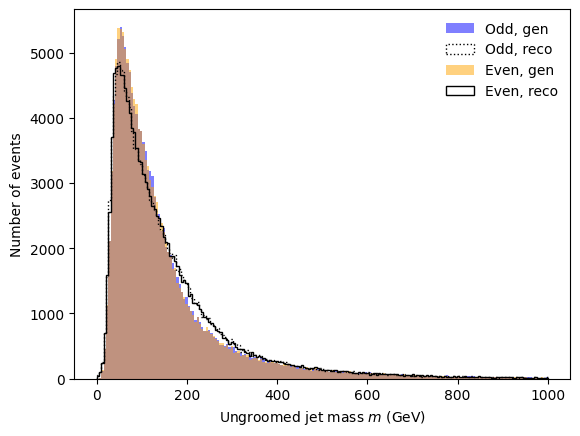

In [13]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(0,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,0],bins=np.linspace(0,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(0,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:,0],bins=np.linspace(0,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Ungroomed jet mass $m$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)



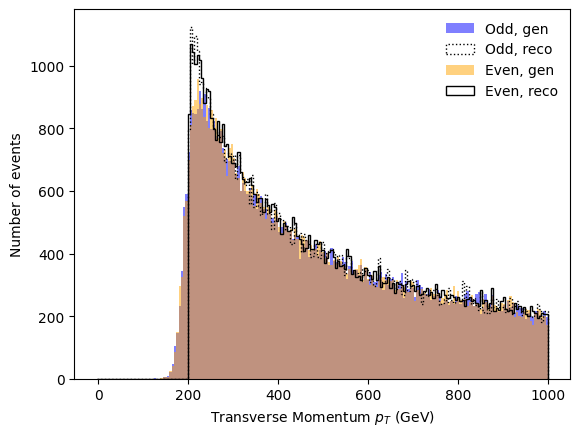

In [14]:
_,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Transverse Momentum $p_{T}$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)


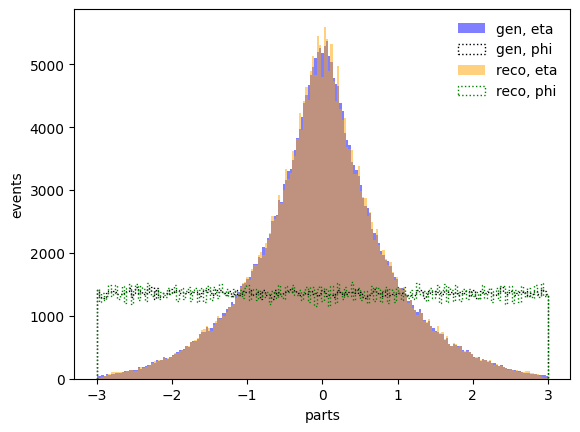

In [15]:
_,_,_=plt.hist(gj0.eta.compute(),bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(gj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(fj0.eta.compute(),bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(fj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

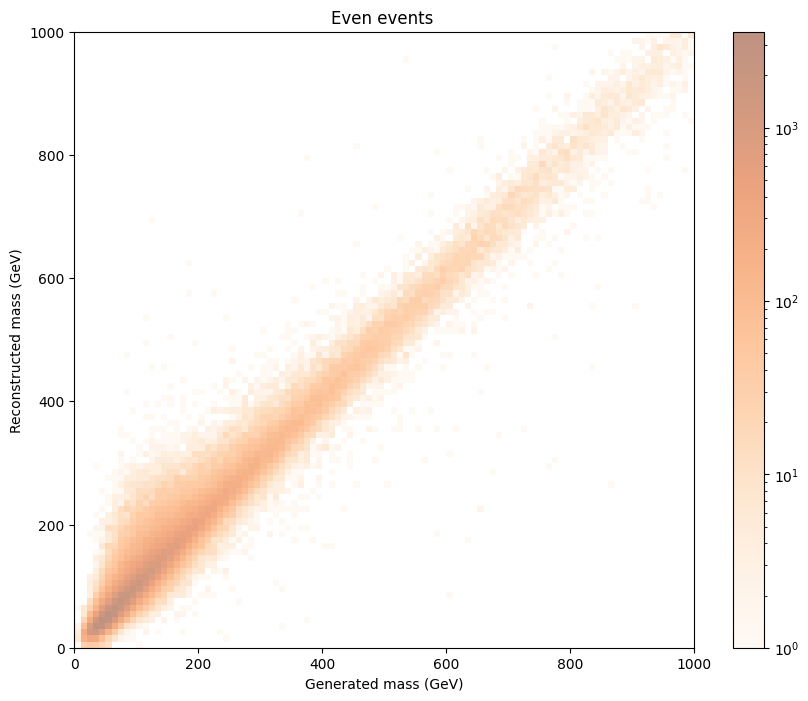

In [18]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:,0], even_reco[:,0], 
           bins=(np.linspace(0,1000,101), np.linspace(0,1000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("Generated mass (GeV)")
plt.ylabel("Reconstructed mass (GeV)")
plt.title("Even events ")
plt.show()

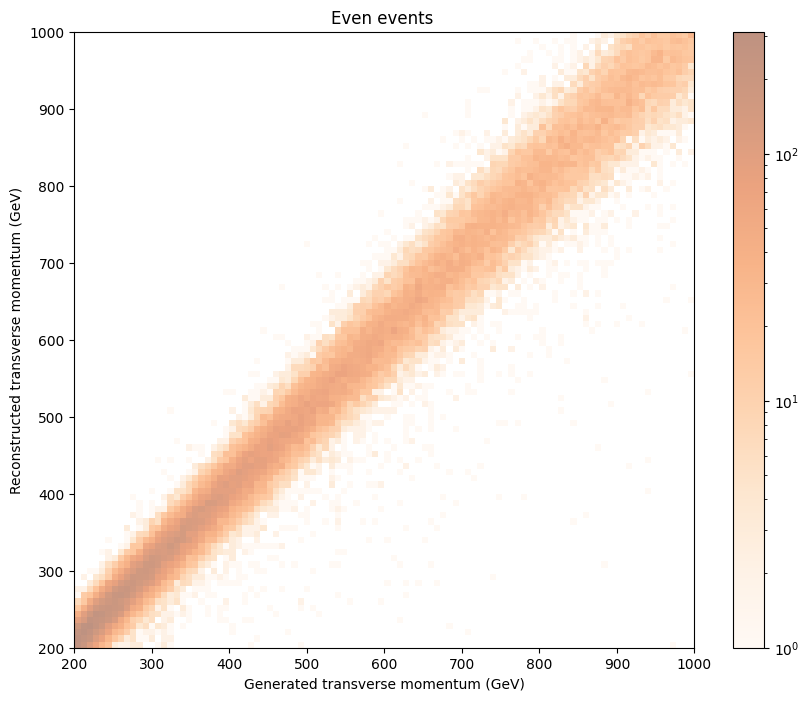

In [19]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:,1], even_reco[:,1], 
           bins=(np.linspace(200,1000,101), np.linspace(200,1000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("Generated transverse momentum (GeV)")
plt.ylabel("Reconstructed transverse momentum (GeV)")
plt.title("Even events ")
plt.show()

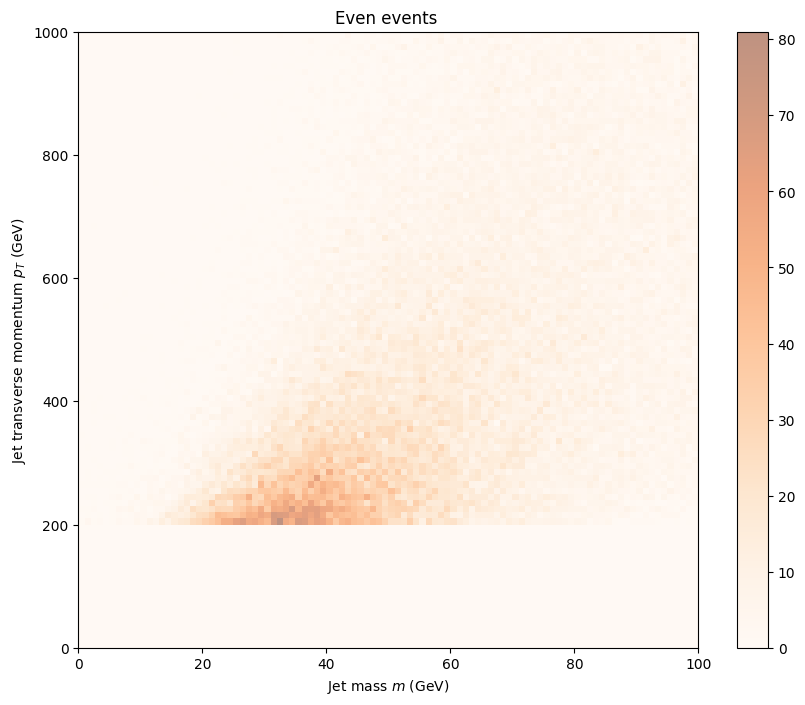

In [22]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_reco[:, 0], even_reco[:, 1], bins=(np.linspace(0,100,101), np.linspace(0,1000,101)), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("Jet mass $m$ (GeV)")
plt.ylabel("Jet transverse momentum $p_T$ (GeV)")
plt.title("Even events ")
plt.show()

In [25]:
#Defining the cnn model with 3 full connected layers, 2D input, 50 nodes per. Sigmoid output, as its binary classification
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [26]:
myweights = of.omnifold(theta0,odd_reco,4,model)

theta0G (142194, 2), labels (142194,), labels unknown (142194,), theta 0(142194, 2, 2), theta unknown s(142194, 2)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [27]:
print("Shape odd_gen:", odd_gen.shape)
print("Shape weights:", myweights.shape)


Shape odd_gen: (142194, 2)
Shape weights: (4, 2, 142194)


In [28]:
myweights

array([[[0.32675138, 0.48588598, 0.30956033, ..., 0.18285933,
         0.16000463, 0.10008253],
        [0.34666124, 0.46872267, 0.30596176, ..., 0.03400153,
         0.16431351, 0.10409115]],

       [[0.82776582, 1.11922693, 0.73058265, ..., 0.08118964,
         0.39235163, 0.24855126],
        [1.00756514, 1.00756514, 1.00756514, ..., 1.00756514,
         1.00756514, 1.00756514]],

       [[1.0035615 , 1.0035615 , 1.0035615 , ..., 1.0035615 ,
         1.0035615 , 1.0035615 ],
        [1.00382006, 1.00382006, 1.00382006, ..., 1.00382006,
         1.00382006, 1.00382006]],

       [[1.00152886, 1.00152886, 1.00152886, ..., 1.00152886,
         1.00152886, 1.00152886],
        [1.00780952, 1.00780952, 1.00780952, ..., 1.00780952,
         1.00780952, 1.00780952]]])

In [31]:
reco_to_gen_weights = of.reweight(odd_reco)

TypeError: reweight() missing 1 required positional argument: 'model'

In [29]:
reco_to_gen_weights

NameError: name 'reco_to_gen_weights' is not defined

In [ ]:
plt.hist(reco_to_gen_weights, bins=np.linspace(0.9, 1.1, 100) )

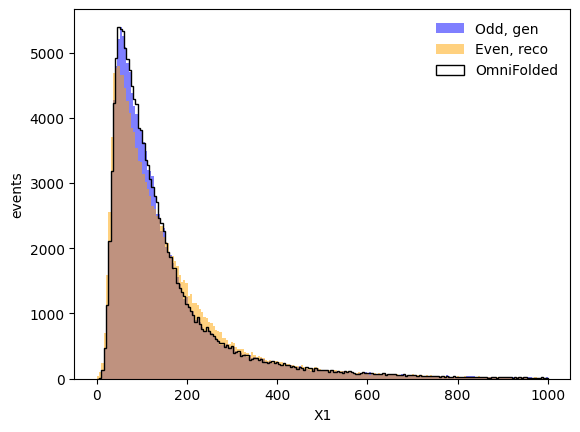

In [32]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(0,1000,200),color='blue',alpha=0.5,label="Odd, gen")
#_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(0,1000,200),color=['orange'],alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:,0],bins=np.linspace(0,1000,200),color=['orange'],alpha=0.5,label="Even, reco")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(0,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

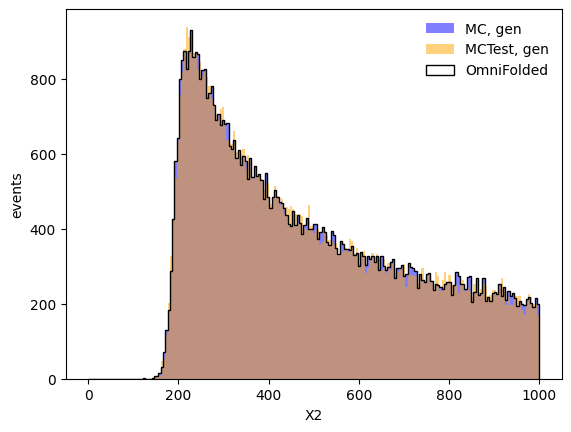

In [33]:
 _,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(0,1000,200),color=['blue'],alpha=0.5,label="MC, gen")
_,_,_=plt.hist(even_gen[:,1],bins=np.linspace(0,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(0,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
#_,_,_=plt.hist(odd_reco[:,1],bins=np.linspace(170,171,20),color=['green'],alpha=0.5, histtype="step",label="got")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

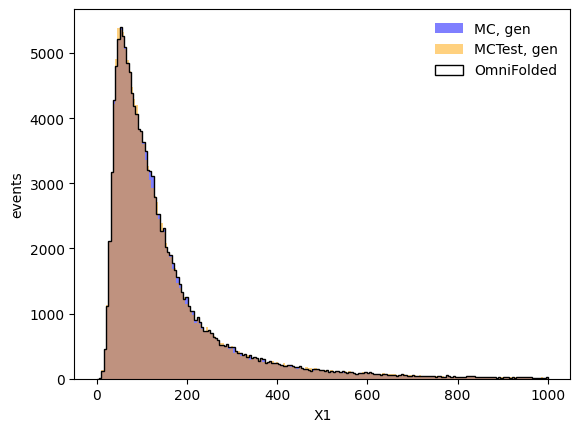

In [34]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(0,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(0,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(0,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

[0.82776582 1.11922693 0.73058265 ... 0.08118964 0.39235163 0.24855126]


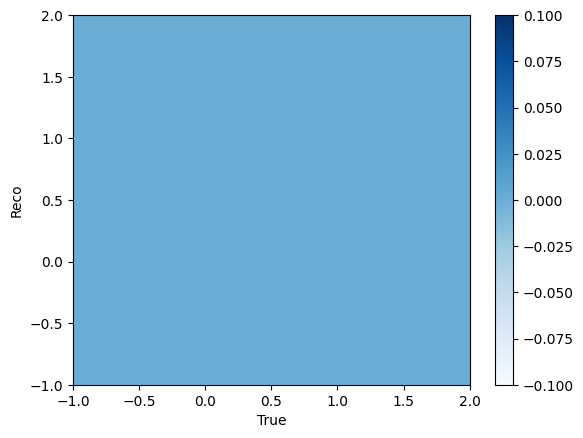

In [35]:
print(myweights[1, 0,:])
#Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(even_reco[:,0],even_gen[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()

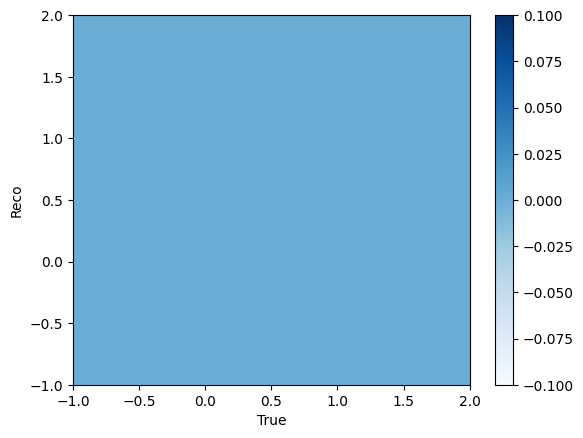

In [36]:
# Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(even_reco[:,1],even_gen[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()